In [ ]:
import pandas as pd
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNetCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [ ]:
df=pd.read_csv("housing.csv")
df=df.dropna()

df['population_per_household']=df['population']/df['households']
df["rooms_per_house"]=df["total_rooms"]/df["households"]
df["bedrooms_per_house"] = df["total_bedrooms"]/df["households"]

df.drop("total_rooms",axis=1,inplace=True)

Q1=df["bedrooms_per_house"].quantile(0.25)
Q3=df["bedrooms_per_house"].quantile(0.75)
IQR=Q3-Q1
lower=Q1-1.5*IQR
upper=Q3+1.5*IQR
df["bedrooms_per_house"]=df["bedrooms_per_house"].clip(lower, upper)

features=['median_income','housing_median_age','population_per_household','ocean_proximity','rooms_per_house','bedrooms_per_house']
X=df[features]
y=df['median_house_value']
y=np.log1p(df['median_house_value'])

numeric_features=['median_income','housing_median_age','population_per_household','rooms_per_house','bedrooms_per_house']
categorical_features=['ocean_proximity']


In [116]:
preprocessor=ColumnTransformer(
    transformers=[
        ('num',Pipeline([
            ('scaler',StandardScaler())
        ]),numeric_features),
        ('cat',OneHotEncoder(drop='first'),categorical_features)
    ]
)
pipeline=Pipeline([
    ('preprocessor',preprocessor),
    ('regressor',ElasticNetCV(alphas=[0.001,0.01,0.1,1,10],l1_ratio=[0.2,0.5,0.8],cv=5,max_iter=10000,random_state=42))
])

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

pipeline.fit(X_train,y_train)
y_pred=pipeline.predict(X_test)

In [117]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(pipeline,X_train,y_train,cv=5,scoring='r2')
print("Average R²:", scores.mean())

Average R²: 0.6101726220987651


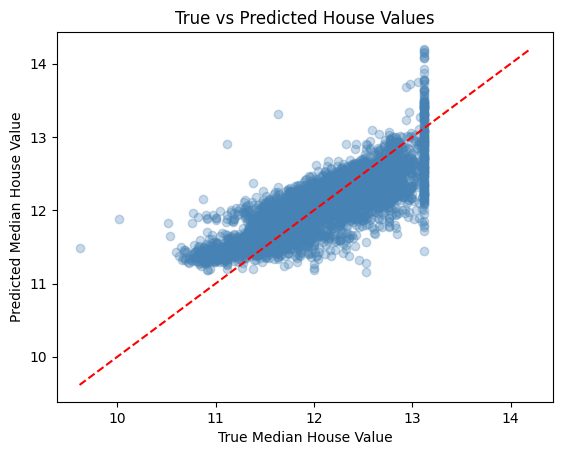

In [118]:
plt.scatter(y_test, y_pred, alpha=0.3, color='steelblue')
plt.xlabel("True Median House Value")
plt.ylabel("Predicted Median House Value")
plt.title("True vs Predicted House Values")
min_val = min(y_test.min(),y_pred.min())
max_val = max(y_test.max(),y_pred.max())
plt.plot([min_val,max_val],[min_val,max_val], 'r--')
plt.show()

In [119]:
import joblib

joblib.dump(preprocessor, "preprocessor.joblib")
joblib.dump(pipeline,"model.joblib")

['model.joblib']